In [ ]:
# Installing the latest stable-baselines3 library.
# !pip install stable-baselines3
!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz
# Ignoring the restart runtime instruction and continue with the cell execution.

In [2]:
# OpenAI gym related import statements.
# Building a simpler environment that works with stablebaselines.
import os
import gym
from gym import spaces
import numpy as np
import random

from gym.envs.registration import EnvSpec
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
# Utility class for saving the best model function.
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)
        return True

In [5]:
# Implementation of the 3x3 road network for MultiAgent RL.
class SizeThreeGridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package):
            self.name = name
            self.gas = gas
            self.package = package

    def __init__(self):
        # super(SizeThreeGridRoadEnv, self).__init__()
        # Defining different possible world configurations.
        self.world_one = np.array([[1, 0, 0],
                      [3, 0, 2],
                      [0, 0, 4]])
        self.world_two = np.rot90(self.world_one)
        self.world_three = np.rot90(self.world_two)
        self.world_four = np.rot90(self.world_three)
        # Even the initial world configuration is defined to be different upon
        # environment instantiation. 
        prob = random.uniform(0, 1)
        # Default value assignment below.
        self.world = self.world_one
        if prob > 0.25 and prob <= 0.25:
            self.world = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world = self.world_four
        self.world_start = self.world # This 'world_start', if reset() is called, never gets used.
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left, 4: stay/pass chance, 5: drop
        # When agent reaches at package location it automatically picks up the package.
        self.action_space = spaces.Discrete(5)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # Defining the driver agents in the environment.
        self.agent_one = self.DriverAgent(1,4,0) # 3 integer value, when carrying package.
        self.agent_two = self.DriverAgent(2,4,0) # 3 integer value, when carrying package.
        self.spec = EnvSpec("SizeThreeGridRoadEnv-v0") # snippet taken from: gym/tests/testing_env.py 

    def reset(self):
        # Game like formulation, each player agent moves one step at a time.
        self.agent_one = self.DriverAgent(1,4,0) # Instantiating agent 1 again.
        self.agent_two = self.DriverAgent(2,4,0) # Instantiating agent 2 again.
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery.
        self.state = 'P'
        self.current_step = 0
        self.max_step = 30 # agent can choose not move as an alternate choice.
        # Selecting a world at random to function with.
        # Even the initial world configuration should be different.
        prob = random.uniform(0, 1)
        if prob > 0.25 and prob <= 0.25:
            self.world_start = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world_start = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world_start = self.world_four
        elif prob < 0.25:
            self.world_start = self.world_one
        self.world = np.copy(self.world_start) # The self.world can be different from intial world.
        # no exploration_prize and bonus_reward as per my design.
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation.
        obs = np.append(obs, [data_to_add], axis=0)
        return obs


    def _take_action(self, action):
        # Agent's name is matched to the array entries for index identification.
        # 'current_player.name' should be updated alongside the array values.
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it.
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # Agent moving upwards.

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # Newly added logic based on three new possible actions.
            elif action == 4  and self.current_player.name != 1:
                pass # Corresponding agent selects to not move at their chance.
            '''
            elif action == 5: # If agent is over the package, it has to pick it up.
                # Agent can choose to drop the package, if it is loaded with it.
                # After, dropping the package the agent should dissappear.
                if self.current_player.package == 3:
                    if self.world[current_pos] == 0:
                        self.world[current_pos] = 3
                        # agent dissappears from the grid after this drop.
                    elif self.world[current_pos] == 4: # Added as extra case, functionally shouldn't be triggered.
                        self.world[current_pos] = self.current_player.name
                        self.state = 'W'
            '''
        else:
            # Player 1's gas is supposed to go empty first.
            # Therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location.
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # agent dissappears from the grid after this drop.
            else:
                self.world[current_pos] = 0 # If gas is finished, agent should dissappear.

        # If gas is empty for both agents, the episode should stop at that instant.
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # Uncomment the below statement out, while debugging.
        # print(self.world) 

        if self.state == "W":
            reward = 1
            done = True
        elif self.state == 'L':
            reward = -10
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends.
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True

        # agents object used to identify agent properties.
        if self.current_player.name == 1 and self.current_step > 2:
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        if done:
            self.render_episode(self.state)
            self.current_episode += 1

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}

    def render_episode(self, win_or_lose):
        # Storing the rendered episodes in a file.
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [6]:
# Note: The 3x3 road network environment doesn't rotate in its simple
# setting implementation.
# Implementation of the Simple 3x3 road network for MultiAgent RL.
class SizeThreeSimpleGridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package):
            self.name = name
            self.gas = gas
            self.package = package

    def __init__(self):
        # super(SizeThreeSimpleGridRoadEnv, self).__init__()
        # Defining different possible world configurations.
        self.world_one = np.array([[1, 0, 0],
                      [3, 0, 2],
                      [0, 0, 4]])
        # self.world_two = np.rot90(self.world_one)
        # self.world_three = np.rot90(self.world_two)
        # self.world_four = np.rot90(self.world_three)
        # Even the initial world configuration is defined to be different upon
        # environment instantiation. 
        # prob = random.uniform(0, 1)
        # Default value assignment below.
        self.world = self.world_one
        # if prob > 0.25 and prob <= 0.25:
        #     self.world = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world = self.world_four
        self.world_start = self.world # This 'world_start', if reset() is called, never gets used.
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left, 4: stay/pass chance, 5: drop
        # When agent reaches at package location it automatically picks up the package.
        self.action_space = spaces.Discrete(5)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # Defining the driver agents in the environment.
        self.agent_one = self.DriverAgent(1,4,0) # 3 integer value, when carrying package.
        self.agent_two = self.DriverAgent(2,4,0) # 3 integer value, when carrying package.
        self.spec = EnvSpec("SizeThreeSimpleGridRoadEnv-v0")

    def reset(self):
        # Game like formulation, each player agent moves one step at a time.
        self.agent_one = self.DriverAgent(1,4,0) # Instantiating agent 1 again.
        self.agent_two = self.DriverAgent(2,4,0) # Instantiating agent 2 again.
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery.
        self.state = 'P'
        self.current_step = 0
        self.max_step = 30 # agent can choose not move as an alternate choice.
        # Selecting a world at random to function with.
        # Even the initial world configuration should be different.
        # prob = random.uniform(0, 1)
        # if prob > 0.25 and prob <= 0.25:
        #     self.world_start = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world_start = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world_start = self.world_four
        # elif prob < 0.25:
        #     self.world_start = self.world_one
        self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # The self.world can be different from intial world.
        # no exploration_prize and bonus_reward as per my design.
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation.
        obs = np.append(obs, [data_to_add], axis=0)
        # Observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector.
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # Agent's name is matched to the array entries for index identification.
        # 'current_player.name' should be updated alongside the array values.
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it.
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # Agent moving upwards.

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # Two Agents can't be at the same place.

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # Reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example.
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment.
                        # Reducing the agent's gas by 1.
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # Newly added logic based on three new possible actions.
            elif action == 4 and self.current_player.name != 1: # passing is only allowed for agent 2.
                pass # Corresponding agent selects to not move at their chance.
            '''
            elif action == 5: # If agent is over the package, it has to pick it up, environment cases encoded above.
                # Agent can choose to drop the package, if it is loaded with it.
                # After, dropping the package the agent should dissappear.
                if self.current_player.package == 3:
                    if self.world[current_pos] == 0:
                        self.world[current_pos] = 3
                        # agent dissappears from the grid after this drop.
                    elif self.world[current_pos] == 4: # Added as extra case, functionally possibly won't be triggered.
                        self.world[current_pos] = self.current_player.name
                        self.state = 'W'
            '''
        else:
            # Player 1's gas is supposed to go empty first.
            # Therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location.
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # agent dissappears from the grid after this drop.
            else:
                self.world[current_pos] = 0 # If gas is finished, agent should dissappear.

        # If gas is empty for both agents, the episode should stop at that instant.
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # Uncomment the below statement out, while debugging.
        # print(self.world) 

        if self.state == "W":
            reward = 1
            done = True
        elif self.state == 'L':
            reward = -10
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends.
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True

        # agents object used to identify agent properties.
        if self.current_player.name == 1 and self.current_step > 2:
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        if done:
            self.render_episode(self.state)
            self.current_episode += 1

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}

    def render_episode(self, win_or_lose):
        # Storing the rendered episodes in a file.
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [7]:
# Create log dir for the agent monitoring and result ploting.
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [18]:
# stable_baseline3 library related import statements.
from stable_baselines3.common.vec_env import DummyVecEnv # it's usage produces 'spec' related error.
from stable_baselines3.common.vec_env import SubprocVecEnv # it's usage produces 'spec' related error.
from stable_baselines3 import PPO
from stable_baselines3 import DQN
# import numpy as np
# result plotter package function
from stable_baselines3.common import results_plotter

# import for generating the rendered output.
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors

# import statements for outputing rendered video.
from IPython.display import HTML
from base64 import b64encode
import os

In [9]:
# Creating the environment for testing.
env_simple = SizeThreeSimpleGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)

In [ ]:
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_simple = PPO("MlpPolicy", env_simple, verbose=1)
model_simple.learn(16000, callback=callback) # testing convergence at 16K steps.

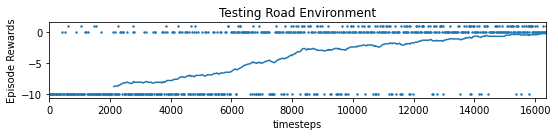

In [11]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

In [12]:
import matplotlib.pyplot as plt
# ploting function utilities for smoothed moving average reward values.
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

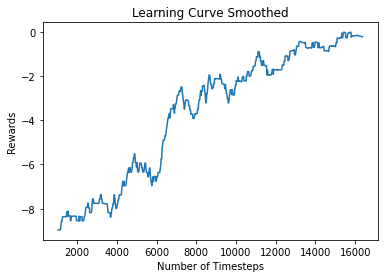

In [13]:
# reward function value curve.
plot_results(log_dir)

In [14]:
# The environment and model memory cleanup.
del env_simple
del model_simple

In [ ]:
# Creating the environment for testing.
env_simple = SizeThreeSimpleGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_simple = PPO("MlpPolicy", env_simple, verbose=1)
model_simple.learn(48000, callback=callback) # testing convergence at 48K steps.

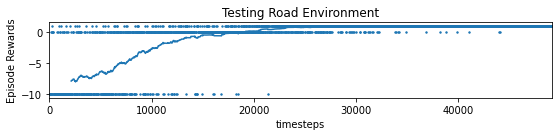

In [16]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

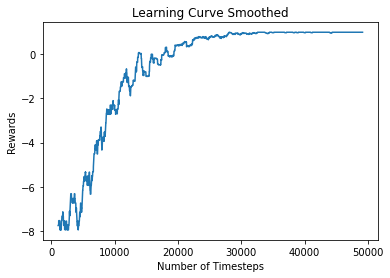

In [17]:
# reward function value curve.
plot_results(log_dir)

In [23]:
def agent_rendering(obs_list):
    fps = 1
    nSeconds = 15
    # matching the dimension dimension of the obs_list with 'nSeconds*fps' values.
    snapshots = obs_list # [ np.random.rand(3,3) for _ in range(nSeconds*fps) ]

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(3,4) )
    colormap = colors.ListedColormap(["lightsteelblue", "chocolate", "tomato", "navajowhite", "yellowgreen", "lightpink"])
    bounds = [0,1,2,3,4,5]
    norm = colors.BoundaryNorm(bounds, colormap.N)
    a = snapshots[0]
    im = plt.imshow(a, cmap=colormap, norm=norm)
    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        im.set_array(snapshots[i])
        return [im]
    anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )
    anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
    print('Done!')

In [ ]:
# Storing obs data into simple road env for ppo algorithm.
ppo_simple_obs_list = []
env_simple = SizeThreeSimpleGridRoadEnv()
result_test = []
obs = env_simple.reset()
for i in range(200):
    action, _states = model_simple.predict(obs)
    # print(action)
    obs, reward, done, info = env_simple.step(action)
    ppo_simple_obs_list.append(obs)
    if done:
        result_test.append(info['state'])
# Printing the output results w/ successful completions.
result_stat = result_test.count('W') / len(result_test)
print(f'Success rate: {result_stat * 100} %')

................Done!


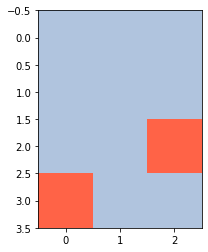

In [26]:
agent_rendering(ppo_simple_obs_list)
# Input video path
save_path = "/content/videos/result.mp4"
# Compressed video path
compressed_path = "test_anim.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=175 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# Creating the environment for testing.
env_dynamic = SizeThreeGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_dynamic = Monitor(env_dynamic, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_dynamic = PPO("MlpPolicy", env_dynamic, verbose=1)
model_dynamic.learn(16000, callback=callback) # testing convergence at 16K steps.

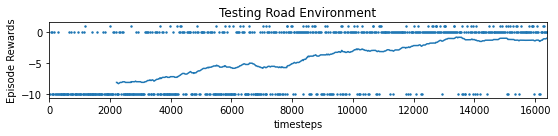

In [29]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

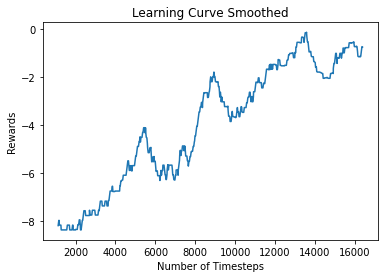

In [30]:
# reward function value curve.
plot_results(log_dir)

In [31]:
# The environment and model memory cleanup.
del env_dynamic
del model_dynamic

In [ ]:
# Creating the environment for testing.
env_dynamic = SizeThreeGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_dynamic = Monitor(env_dynamic, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_dynamic = PPO("MlpPolicy", env_dynamic, verbose=1)
model_dynamic.learn(48000, callback=callback) # testing convergence at 48K steps.

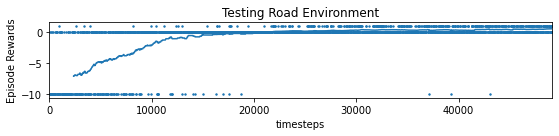

In [ ]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

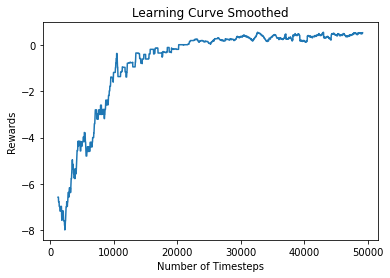

In [ ]:
# reward function value curve.
plot_results(log_dir)

In [ ]:
# The environment and model memory cleanup.
del env_dynamic
del model_dynamic

In [ ]:
# Creating the environment for testing.
env_dynamic = SizeThreeGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_dynamic = Monitor(env_dynamic, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_dynamic = PPO("MlpPolicy", env_dynamic, verbose=1)
model_dynamic.learn(64000, callback=callback) # testing convergence at 64K steps.

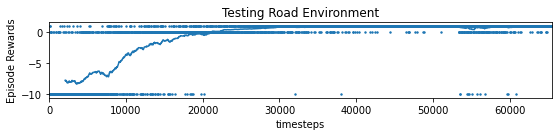

In [33]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

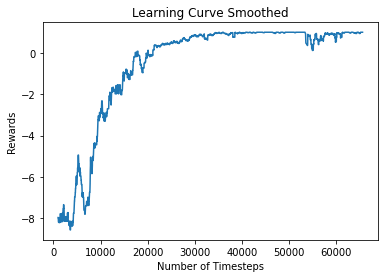

In [34]:
# reward function value curve.
plot_results(log_dir)
# Final observation: Even after making the 1.3x budget in comparison 
# to the simpler environment version, the training still haven't stabilized
# for the dynamic environment. Hence, the good generalization with PPO
# isn't obtained in dynamic environment for this setting.

In [ ]:
# Storing obs data into simple road env for ppo algorithm.
ppo_dynamic_obs_list = []
env_dynamic = SizeThreeSimpleGridRoadEnv()
result_test = []
obs = env_dynamic.reset()
for i in range(200):
    action, _states = model_dynamic.predict(obs)
    # print(action)
    obs, reward, done, info = env_dynamic.step(action)
    ppo_dynamic_obs_list.append(obs)
    if done:
        result_test.append(info['state'])

# Printing the output results w/ successful completions.
result_stat = result_test.count('W') / len(result_test)
print(f'Success rate: {result_stat * 100} %')

................Done!


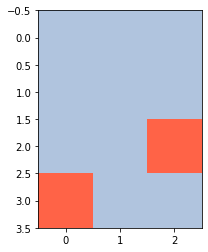

In [36]:
agent_rendering(ppo_simple_obs_list)
# Input video path
save_path = "/content/videos/result.mp4"
# Compressed video path
compressed_path = "test_anim.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=175 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# DQN Model Learning for Simple Road Environment Task

In [ ]:
# Creating the environment for testing.
env_simple = SizeThreeSimpleGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_simple = DQN("MlpPolicy", env_simple, verbose=1)
model_simple.learn(32000, callback=callback) # testing convergence at 32K steps.

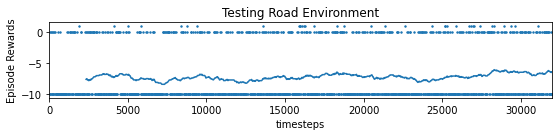

In [ ]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

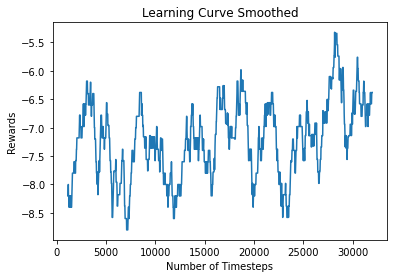

In [ ]:
# reward function value curve.
plot_results(log_dir)

In [ ]:
# The environment and model memory cleanup.
del env_simple
del model_simple

In [ ]:
# Creating the environment for testing.
env_simple = SizeThreeSimpleGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_simple = PPO("MlpPolicy", env_simple, verbose=1)
model_simple.learn(64000, callback=callback) # testing convergence at 64K steps.

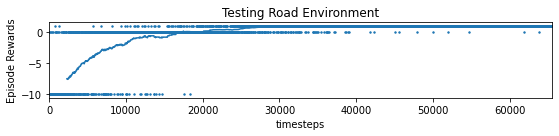

In [ ]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

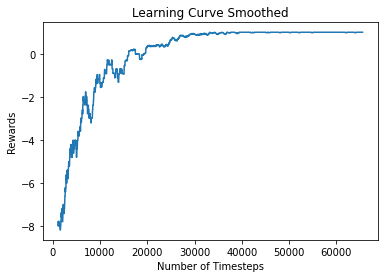

In [ ]:
# reward function value curve.
plot_results(log_dir)

In [ ]:
# Creating the environment for testing.
env_dynamic = SizeThreeGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_dynamic = Monitor(env_dynamic, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_dynamic = DQN("MlpPolicy", env_dynamic, verbose=1)
model_dynamic.learn(32000, callback=callback) # testing convergence at 32K steps.

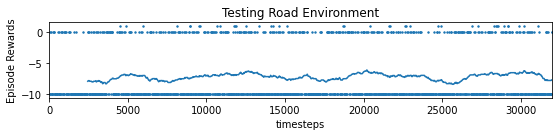

In [ ]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

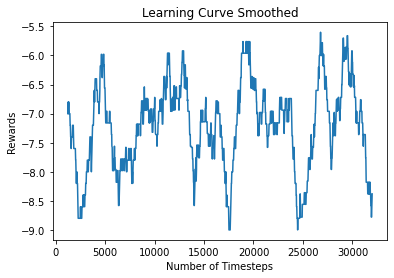

In [ ]:
# reward function value curve.
plot_results(log_dir)

In [ ]:
# The environment and model memory cleanup.
del env_dynamic
del model_dynamic

In [ ]:
# Creating the environment for testing.
env_dynamic = SizeThreeGridRoadEnv()
# Logs will be saved in log_dir/monitor.csv
env_dynamic = Monitor(env_dynamic, log_dir)
# Training sample environment policy for checking the env functionality.
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_dynamic = DQN("MlpPolicy", env_dynamic, verbose=1)
model_dynamic.learn(64000, callback=callback) # testing convergence at 64K steps.

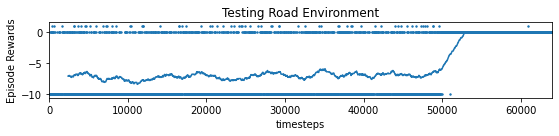

In [ ]:
# Helper function from the ploting library.
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Testing Road Environment")

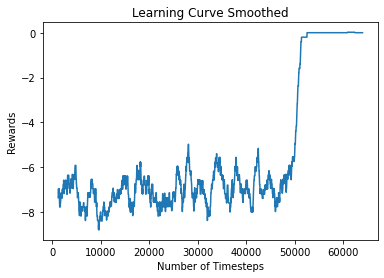

In [ ]:
# reward function value curve.
plot_results(log_dir)

In [ ]:
# Listing all the packages with corresponding versions,
# for possibly addressing package dependency related issues in the future.
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                0.1.12
ale-py                        0.7.4
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
AutoROM                       0.4.2
AutoROM.accept-rom-license    0.4.2
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.8
bokeh                         2.